### Tutorial 08: Building a Convolutional Neural Network (CNN) from Scratch

In this tutorial, we will learn how to build a Convolutional Neural Network (CNN) from scratch using customized layers. Please note the following warning before proceeding:
---

⚠️ Important Warning
The codes in this tutorial are designed to demonstrate the internal workings of CNN layers (e.g., convolution, pooling, and activation) and are not computationally optimized. Running these codes can be computationally intensive and may cause your kernel or computer to crash if your system does not have sufficient computing resources (e.g., RAM or processing power).

Do not run this tutorial if you are unsure whether your computer meets the required performance standards.

In [1]:
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
from layers.simpleCNN import SimpleCNN

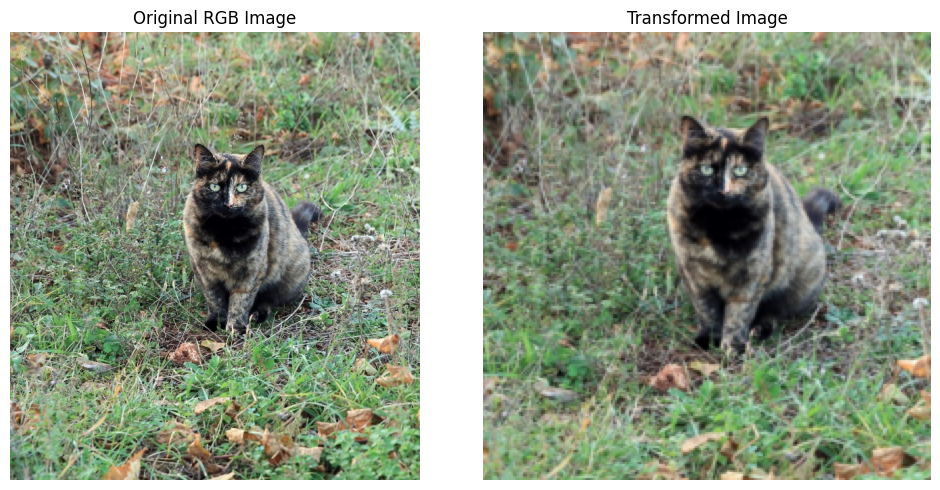

In [2]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Load the image using OpenCV
image_path = "./data/pet_images/cat_01.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

# Convert BGR to RGB (OpenCV loads images in BGR format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to PIL Image
image_pil = Image.fromarray(image_rgb)

# Preprocess the image for a model
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image_pil)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
denormalized_image = input_tensor * std[:, None, None] + mean[:, None, None]
image_np = denormalized_image.permute(1, 2, 0).numpy()

# Display both images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(image_rgb)
axes[0].set_title("Original RGB Image")
axes[0].axis("off")

# Transformed Image
axes[1].imshow(image_np)
axes[1].set_title("Transformed Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()


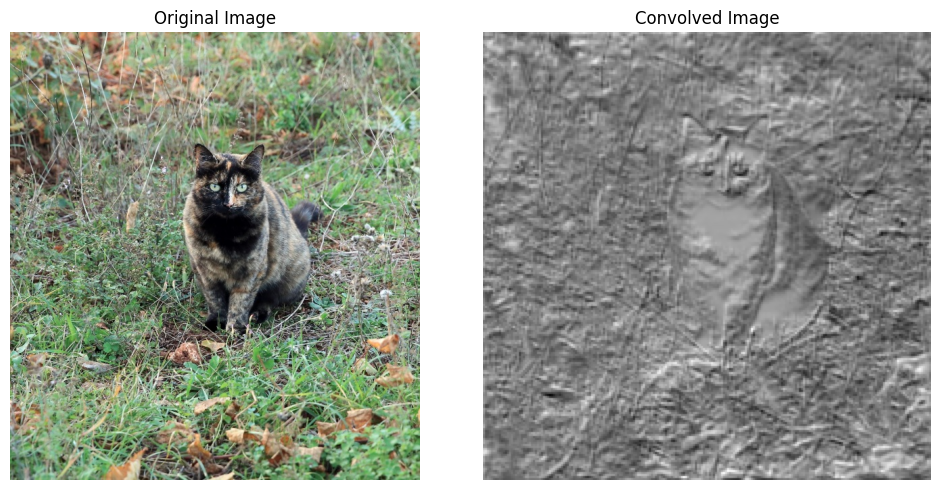

In [3]:
from layers.convolution import Convolution

image_tensor = preprocess(image_pil).unsqueeze(0)  

conv_layer = Convolution(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
convolved_image = conv_layer(image_tensor)

convolved_image_np = convolved_image.detach().numpy()[0, 0]  


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image_rgb)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Convolved Image
axes[1].imshow(convolved_image_np, cmap="gray")
axes[1].set_title("Convolved Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

(-0.5, 223.5, 223.5, -0.5)

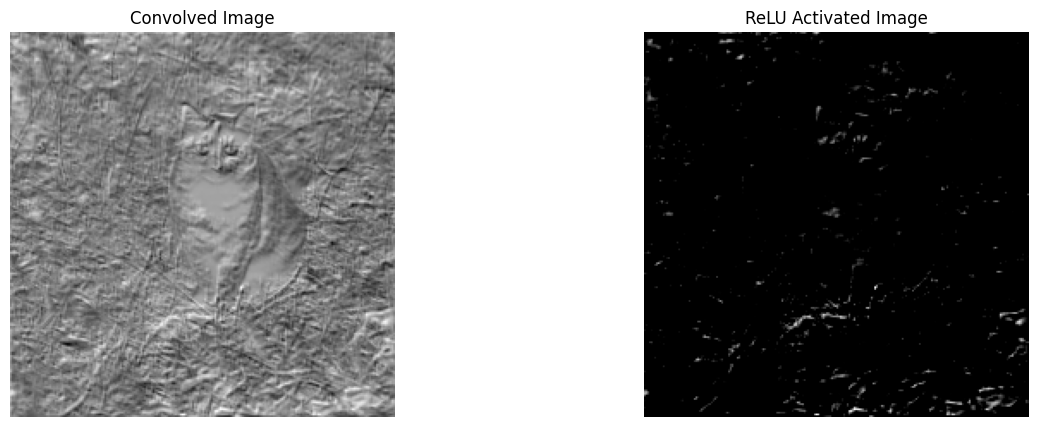

In [4]:
from layers.relu import ReLU

relu_layer = ReLU()
relu_output = relu_layer(convolved_image)
relu_output_np = relu_output.detach().numpy()[0, 0] 

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(convolved_image_np, cmap="gray")
axes[0].set_title("Convolved Image")
axes[0].axis("off")

axes[1].imshow(relu_output_np, cmap="gray")
axes[1].set_title("ReLU Activated Image")
axes[1].axis("off")

In [5]:
from layers.pooling import Pooling

pool_layer = Pooling(kernel_size=2, stride=2, pooling_type="max")
pooled_image = pool_layer(relu_output)



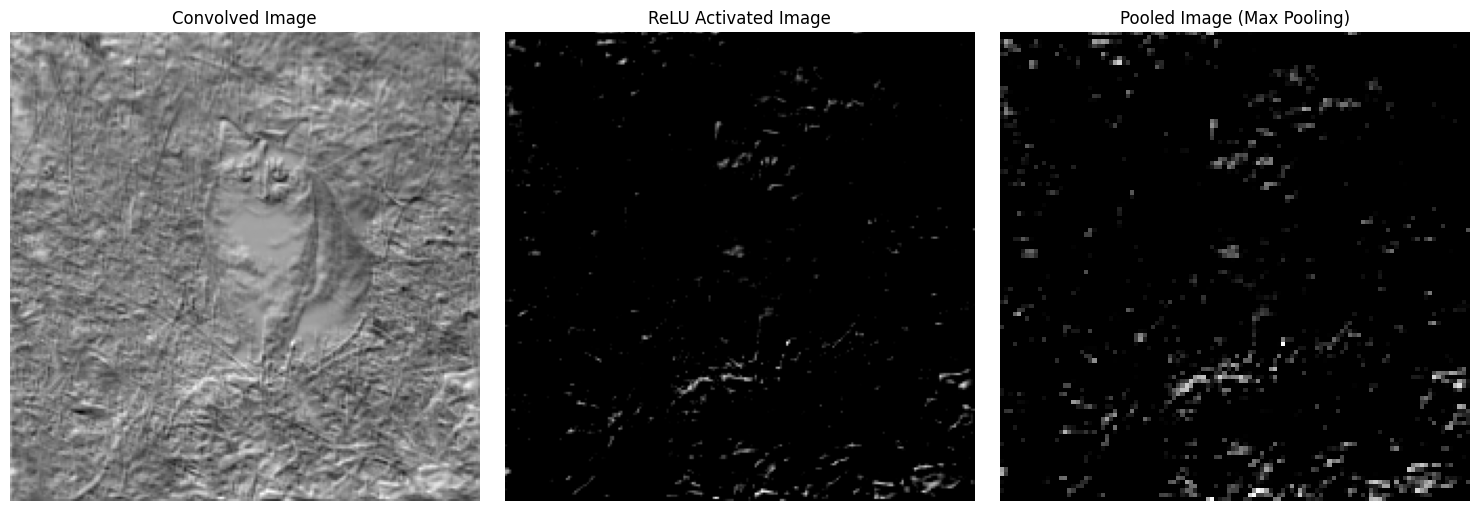

In [6]:
convolved_image_np = convolved_image.detach().numpy()[0, 0]  
relu_output_np = relu_output.detach().numpy()[0, 0]  
pooled_image_np = pooled_image.detach().numpy()[0, 0] 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Convolved Image
axes[0].imshow(convolved_image_np, cmap="gray")
axes[0].set_title("Convolved Image")
axes[0].axis("off")

# ReLU Output
axes[1].imshow(relu_output_np, cmap="gray")
axes[1].set_title("ReLU Activated Image")
axes[1].axis("off")

# Pooled Image
axes[2].imshow(pooled_image_np, cmap="gray")
axes[2].set_title("Pooled Image (Max Pooling)")
axes[2].axis("off")

plt.tight_layout()
plt.show()
